In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [6]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3
CLASS_NAMES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

def read_and_decode(filename, resize_dims):
    img_bytes = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img_bytes, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, resize_dims)
    return img

def parse_csvline(csv_line):
    record_default = ["", ""]
    filename, label_string = tf.io.decode_csv(csv_line, record_default)
    img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
    label = tf.where(tf.equal(CLASS_NAMES, label_string))[0, 0]
    return img, label

In [7]:
train_dataset = (
            tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv")
            .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
            .batch(8)
            .prefetch(tf.data.AUTOTUNE)
)

eval_dataset = (
        tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/eval_set.csv")
        .map(parse_csvline, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(8)
        .prefetch(tf.data.AUTOTUNE)
)

In [8]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS),
    include_top = False,
    weights = "imagenet"
)

base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(len(CLASS_NAMES),activation = "softmax")
])

In [10]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate=0.0001),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,509 (8.66 MB)

 Trainable params: 8,965 (35.02 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [11]:
history = model.fit(train_dataset,
                    validation_data=eval_dataset,
                    epochs = 10
                    )

Epoch 1/10
    413/Unknown 35s 77ms/step - accuracy: 0.3758 - loss: 1.6605

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


413/413 ━━━━━━━━━━━━━━━━━━━━ 40s 88ms/step - accuracy: 0.3761 - loss: 1.6597 - val_accuracy: 0.6784 - val_loss: 0.9216
Epoch 2/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 35s 85ms/step - accuracy: 0.6882 - loss: 0.8505 - val_accuracy: 0.7622 - val_loss: 0.6898
Epoch 3/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 35s 86ms/step - accuracy: 0.7596 - loss: 0.6787 - val_accuracy: 0.7865 - val_loss: 0.5906
Epoch 4/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 36s 88ms/step - accuracy: 0.7932 - loss: 0.5897 - val_accuracy: 0.8000 - val_loss: 0.5377
Epoch 5/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 35s 85ms/step - accuracy: 0.8184 - loss: 0.5305 - val_accuracy: 0.8270 - val_loss: 0.5055
Epoch 6/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 35s 84ms/step - accuracy: 0.8349 - loss: 0.4861 - val_accuracy: 0.8324 - val_loss: 0.4840
Epoch 7/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 36s 86ms/step - accuracy: 0.8448 - loss: 0.4505 - val_accuracy: 0.8297 - val_loss: 0.4688
Epoch 8/10
413/413 ━━━━━━━━━━━━━━━━━━━━ 35s 85ms/step - accuracy: 0.8577 - loss: 0.4208 - val_accurac

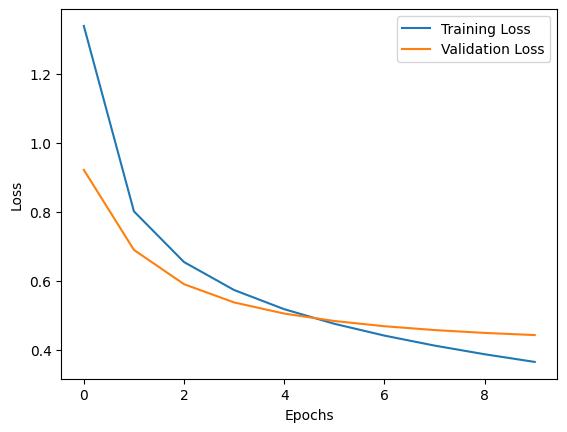

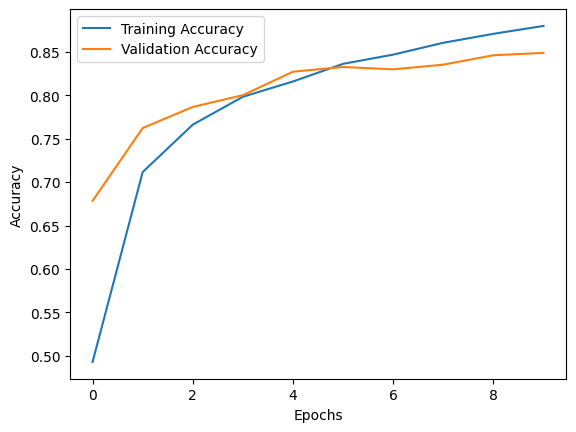

In [13]:
plt.plot(history.history["loss"],label = "Training Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"],label = "Training Accuracy")
plt.plot(history.history["val_accuracy"],label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()